# physio

toolbox de CMO pour **ecg** et **respiration**

- Traite le signal respi --> Respiration Features
- Traite le signal ECG --> Heart rate variability
- Construit le signal de fréquence cardiaque instantanée à partir de l'ECG
- Calcule la RSA (arrythmie sinusale respiratoire) cycle respiratoire par cycle respiratoire

# Liens utiles 

- Documentation : https://physio.readthedocs.io/en/latest/index.html
- github : https://github.com/samuelgarcia/physio/tree/main
- Article  : https://www.eneuro.org/content/10/10/ENEURO.0197-23.2023

# Installation
- pip install physio

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path

import physio

# %matplotlib inline
%matplotlib widget

# read data

In [7]:
folder = Path('/home/samuel/Documents/Formation_2025_Python_data_analyse/notebooks/data/')
eeg_file = folder / 'subML05_ses04.vhdr'

In [8]:
physio.read_one_channel(eeg_file, format='brainvision', channel_name=None)

ValueError: None do not exists in this file.
 Possible channels : ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'ECG', 'GSR', 'RespiNasale', 'RespiVentrale']

In [9]:
raw_resp, srate = physio.read_one_channel(eeg_file, format='brainvision', channel_name='RespiNasale')
print(raw_resp.shape, srate)

(3182940,) 1000.0


In [10]:
raw_ecg, srate = physio.read_one_channel(eeg_file, format='brainvision', channel_name='ECG')
print(raw_resp.shape, srate)

(3182940,) 1000.0


In [11]:
raw_resp *= -1
raw_ecg *= -1

In [12]:
times = np.arange(raw_resp.size) / srate

### Define protocol periods

In [13]:
periods = pd.DataFrame({
    'block_type': ['free', 'free', 'fast', 'fast', 'fast', 'base', 'base', 'base', 'slow', 'slow', 'slow', ],
    'trial_num': [ 1, 2, 1, 2, 3, 1, 2, 3, 1, 2, 3,],
    'start_time' : [56.938, 2869.336, 634.304, 1863.984, 2610.284, 883.562, 1372.779, 1611.302, 1132.622, 2122.235, 2368.016],
    'duration' : [300., 300., 180., 180., 180., 180., 180., 180., 180., 180., 180.,  ],
    
})
periods['stop_time'] = periods['start_time'] + periods['duration']
periods = periods.set_index(['block_type', 'trial_num'])
periods

start_time  duration  stop_time
block_type trial_num                                 
free       1              56.938     300.0    356.938
           2            2869.336     300.0   3169.336
fast       1             634.304     180.0    814.304
           2            1863.984     180.0   2043.984
           3            2610.284     180.0   2790.284
base       1             883.562     180.0   1063.562
           2            1372.779     180.0   1552.779
           3            1611.302     180.0   1791.302
slow       1            1132.622     180.0   1312.622
           2            2122.235     180.0   2302.235
           3            2368.016     180.0   2548.016

# raw plots

Text(0.5, 0, 'Time (sec)')

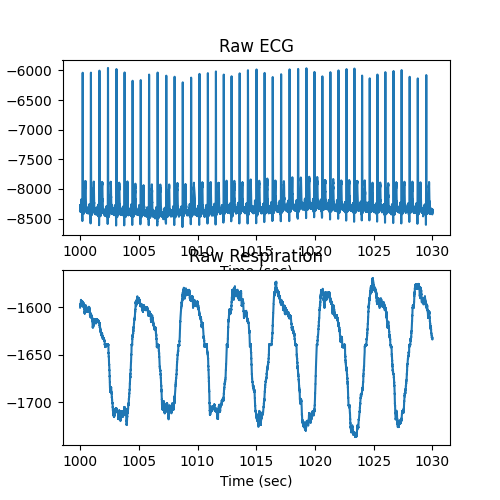

In [17]:
%matplotlib widget
start, stop = 1000, 1030

mask_t = (times > start) & (times < stop)

fig, axs = plt.subplots(nrows = 2, figsize = (5,5))

ax = axs[0]
ax.set_title('Raw ECG')
ax.plot(times[mask_t], raw_ecg[mask_t])
ax.set_xlabel('Time (sec)')

ax = axs[1]
ax.set_title('Raw Respiration')
ax.plot(times[mask_t], raw_resp[mask_t])
ax.set_xlabel('Time (sec)')

# respiration analysis

## parameters

In [23]:
resp, resp_cycles = physio.compute_respiration(raw_resp, srate, parameter_preset='human_airflow')


In [24]:
physio.get_respiration_parameters('human_airflow') # human_airflow, rat_plethysmo, rat_etisens_belt

{'preprocess': {'band': 7.0,
  'btype': 'lowpass',
  'ftype': 'bessel',
  'order': 5,
  'normalize': False},
 'smooth': {'win_shape': 'gaussian', 'sigma_ms': 60.0},
 'cycle_detection': {'method': 'crossing_baseline',
  'inspiration_adjust_on_derivative': False},
 'baseline': {'baseline_mode': 'median'},
 'features': {'compute_volume': True, 'compute_amplitude': True},
 'cycle_clean': {'low_limit_log_ratio': 4.0}}

In [25]:
# custum params
parameters = physio.get_respiration_parameters('human_airflow')
parameters['preprocess']['band'] = 7.5
resp, resp_cycles = physio.compute_respiration(raw_resp, srate, parameters = parameters)

In [26]:
print(resp.shape, resp_cycles.shape)

(3182940,) (814, 17)


## table of respiratory cycles

In [27]:
resp_cycles.head(10)

,inspi_index,expi_index,next_inspi_index,inspi_time,expi_time,next_inspi_time,cycle_duration,inspi_duration,expi_duration,cycle_freq,cycle_ratio,inspi_volume,expi_volume,total_amplitude,inspi_amplitude,expi_amplitude,total_volume
0,764,2125,5138,0.764,2.125,5.138,4.374,1.361,3.013,0.228624,0.311157,198.189314,131.727261,330.080908,217.748526,112.332382,329.916575
1,5138,6282,7941,5.138,6.282,7.941,2.803,1.144,1.659,0.356761,0.408134,141.511906,118.799565,296.245330,192.152110,104.093220,260.311471
2,7941,9198,12060,7.941,9.198,12.060,4.119,1.257,2.862,0.242777,0.305171,158.408792,92.539070,317.972243,225.133602,92.838641,250.947863
3,12060,13354,15354,12.060,13.354,15.354,3.294,1.294,2.000,0.303582,0.392835,198.087093,156.305089,377.956678,262.212130,115.744547,354.392182
4,15354,16738,19790,15.354,16.738,19.790,4.436,1.384,3.052,0.225428,0.311993,144.264953,98.949695,252.203350,158.586441,93.616909,243.214647
5,19790,21041,22703,19.790,21.041,22.703,2.913,1.251,1.662,0.343289,0.429454,150.902105,111.802665,308.328657,198.746884,109.581774,262.704769
6,22703,23902,25441,22.703,23.902,25.441,2.738,1.199,1.539,0.365230,0.437911,153.936631,88.935726,295.404925,193.846943,101.557983,242.872356
7,25441,26607,28314,25.441,26.607,28.314,2.873,1.166,1.707,0.348068,0.405848,120.546327,109.097119,277.202824,159.956807,117.246017,229.643446
8,28314,29459,31216,28.314,29.459,31.216,2.902,1.145,1.757,0.344590,0.394555,118.675091,84.001139,286.237916,193.029328,93.208588,202.676230
9,31216,32278,34053,31.216,32.278,34.053,2.837,1.062,1.775,0.352485,0.374339,106.003469,64.996686,248.504019,161.849536,86.654483,171.000155


## preprocess signal

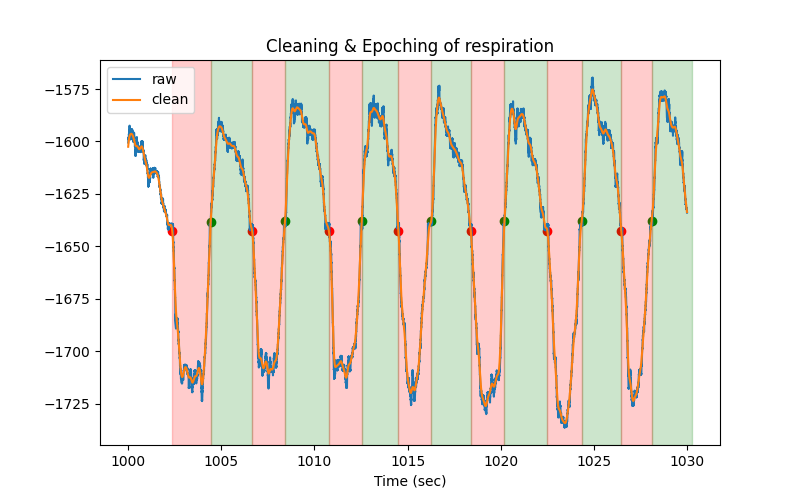

In [54]:
start, stop = 1000, 1030

mask_t = (times > start) & (times < stop)

mask_cycles_t = (resp_cycles['inspi_time'] > start) &  (resp_cycles['expi_time'] < stop)
resp_cycles_window = resp_cycles[mask_cycles_t]
inspi, expi = resp_cycles_window['inspi_time'], resp_cycles_window['expi_time']
inspi_ind, expi_ind = resp_cycles_window['inspi_index'], resp_cycles_window['expi_index']

fig, ax = plt.subplots(figsize = (8,5))
ax.set_title('Cleaning & Epoching of respiration')
ax.plot(times[mask_t], raw_resp[mask_t], label = 'raw')
ax.plot(times[mask_t], resp[mask_t], label = 'clean')
ax.scatter(inspi, resp[inspi_ind], color = 'r')
ax.scatter(expi, resp[expi_ind], color = 'g')

for i, row in resp_cycles_window.iterrows():
    ax.axvspan(xmin = row['inspi_time'], xmax = row['expi_time'], color = 'r', alpha = 0.2)
    ax.axvspan(xmin = row['expi_time'], xmax = row['next_inspi_time'], color = 'g', alpha = 0.2)

ax.set_xlabel('Time (sec)')
ax.legend()

In [29]:
periods

start_time  duration  stop_time
block_type trial_num                                 
free       1              56.938     300.0    356.938
           2            2869.336     300.0   3169.336
fast       1             634.304     180.0    814.304
           2            1863.984     180.0   2043.984
           3            2610.284     180.0   2790.284
base       1             883.562     180.0   1063.562
           2            1372.779     180.0   1552.779
           3            1611.302     180.0   1791.302
slow       1            1132.622     180.0   1312.622
           2            2122.235     180.0   2302.235
           3            2368.016     180.0   2548.016

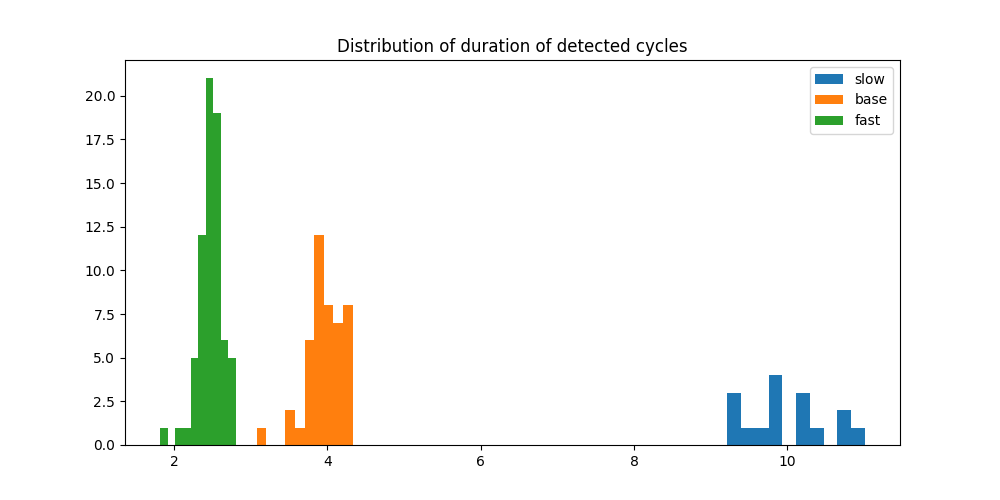

In [30]:

fig, ax = plt.subplots(figsize = (10,5))
for block_type in ('slow', 'base', 'fast'):
    start_time = periods.loc[(block_type, 1),'start_time']
    stop_time = periods.loc[(block_type, 1),'stop_time']

    mask = (resp_cycles['inspi_time'] > start_time) & (resp_cycles['next_inspi_time'] < stop_time)

    ax.hist(resp_cycles[mask]['cycle_duration'], bins=10, label=block_type)
    
ax.set_title('Distribution of duration of detected cycles')
ax.legend()

# ECG analysis

## parameters

In [31]:
ecg, ecg_peaks = physio.compute_ecg(raw_ecg, srate, parameter_preset='human_ecg')

In [32]:
physio.get_ecg_parameters('human_ecg')
# physio.get_ecg_parameters('rat_ecg')

{'preprocess': {'band': [5.0, 45.0],
  'ftype': 'bessel',
  'order': 5,
  'normalize': True},
 'peak_detection': {'thresh': 'auto', 'exclude_sweep_ms': 4.0},
 'peak_clean': {'min_interval_ms': 400.0}}

In [33]:
parameters = physio.get_ecg_parameters('human_ecg')
parameters['peak_detection']['thresh'] = 5
ecg, ecg_peaks2 = physio.compute_ecg(raw_ecg, srate, parameters = parameters)

In [34]:
ecg_peaks.head(15)

,peak_index,peak_time
0,641,0.641
1,1346,1.346
2,2006,2.006
3,2660,2.660
4,3336,3.336
5,4051,4.051
6,4761,4.761
7,5481,5.481
8,6162,6.162
9,6835,6.835


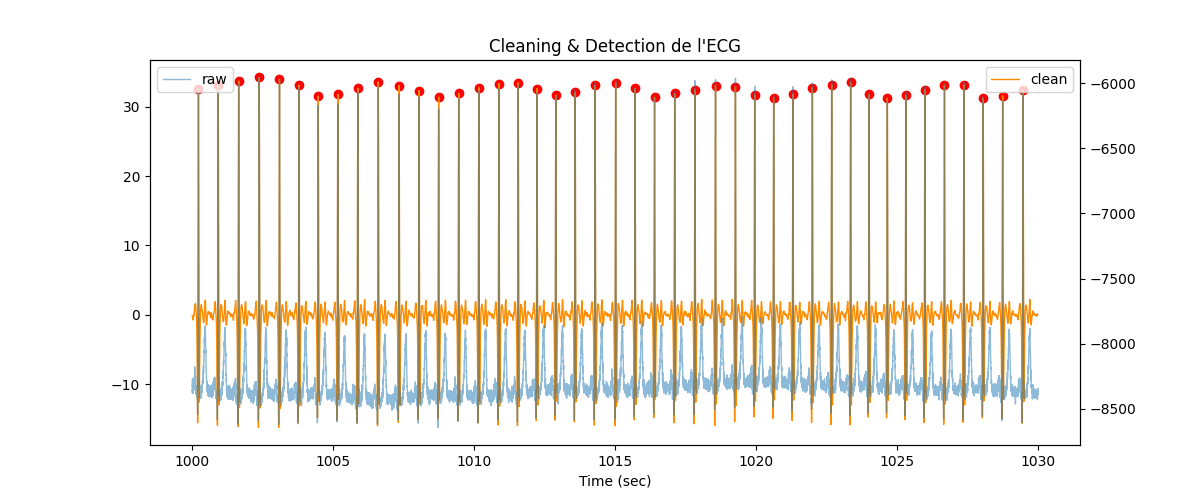

In [35]:
start, stop = 1000, 1030

mask_t = (times > start) & (times < stop)

peaks_mask = (ecg_peaks['peak_time'] > start) & (ecg_peaks['peak_time'] < stop)
r_peaks = ecg_peaks[peaks_mask]

fig, ax = plt.subplots(figsize = (12,5))
ax.set_title("Cleaning & Detection de l'ECG")
ax2 = ax.twinx()
ax2.plot(times[mask_t], raw_ecg[mask_t], lw = 1, label = 'raw', alpha = 0.5)

ax.plot(times[mask_t], ecg[mask_t], lw = 1, label = 'clean', color = 'darkorange')
ax.scatter(r_peaks['peak_time'], ecg[r_peaks['peak_index']], color = 'r')

ax.set_xlabel('Time (sec)')
ax.legend()
ax2.legend(loc = 2)

### heart rate variability (HRV)

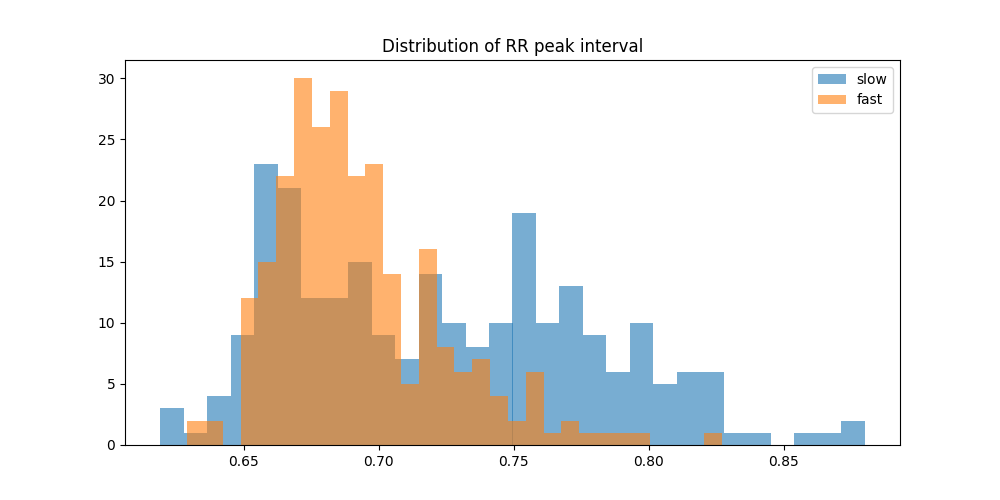

In [36]:
fig, ax = plt.subplots(figsize = (10,5))
for block_type in ('slow', 'fast'):
    start_time = periods.loc[(block_type, 1),'start_time']
    stop_time = periods.loc[(block_type, 1),'stop_time']

    mask = (ecg_peaks['peak_time'] > start_time) & (ecg_peaks['peak_time'] < stop_time)
    peak_times = ecg_peaks[mask]['peak_time'].values

    rri = np.diff(peak_times)

    ax.hist(rri, bins=30, label=block_type, alpha=0.6)
    
ax.set_title('Distribution of RR peak interval')
ax.legend()

### comput metrics per period

In [37]:
hrv_metrics = []
for ind, period in periods.iterrows():
    start_time = period['start_time']
    stop_time = period['stop_time']

    mask = (ecg_peaks['peak_time'] > start_time) & (ecg_peaks['peak_time'] < stop_time)
    peaks_period = ecg_peaks[mask]

    metrics = physio.compute_ecg_metrics(peaks_period, min_interval_ms=500., max_interval_ms=2000.)
    hrv_metrics.append(metrics)
hrv_metrics = pd.concat(hrv_metrics, axis=1).T
hrv_metrics = hrv_metrics.set_index(periods.index)
hrv_metrics


HRV_Mean     HRV_SD  HRV_Median    HRV_Mad    HRV_CV  \
block_type trial_num                                                           
free       1          686.164760  39.253915       687.0  37.065055  0.057208   
           2          734.578431  52.168644       729.0  41.512862  0.071018   
fast       1          692.667954  30.936568       687.0  25.204238  0.044663   
           2          707.201581  21.233570       706.0  20.756431  0.030025   
           3          733.418033  25.519629       733.0  28.169442  0.034795   
base       1          698.980545  23.133759       699.0  23.721635  0.033096   
           2          695.302326  23.264107       694.0  22.980334  0.033459   
           3          707.735178  19.496149       705.0  20.756431  0.027547   
slow       1          723.737903  56.167088       721.0  68.941003  0.077607   
           2          746.037500  60.728311       740.5  69.682304  0.081401   
           3          747.512500  61.878778       740.0  76.354014  0.082780   

                       HRV_MCV  HRV_Asymmetry  HRV_RMSSD  
block_type trial_num                                      
free       1          0.053952       0.835240  20.334756  
           2          0.056945      -5.578431  29.881050  
fast       1          0.036687      -5.667954  21.812005  
           2          0.029400      -1.201581  22.690289  
           3          0.038430      -0.418033  29.777778  
base       1          0.033937       0.019455  17.338316  
           2          0.033113      -1.302326  17.817711  
           3          0.029442      -2.735178  16.906019  
slow       1          0.095619      -2.737903  27.439665  
           2          0.094102      -5.537500  31.091914  
           3          0.103181      -7.512500  30.231879

# Arrythmie sinusale respiratoire (RSA)

## instantaneous heart rate

In [39]:
interpolation_srate = 150.
rate_times = np.arange(0,  times[-1] + 1/interpolation_srate, 1/interpolation_srate) # 50Hz
instantaneous_cardiac_rate = physio.compute_instantaneous_rate(ecg_peaks, rate_times,
                                                               units='bpm', interpolation_kind='linear')

(900.0, 930.0)

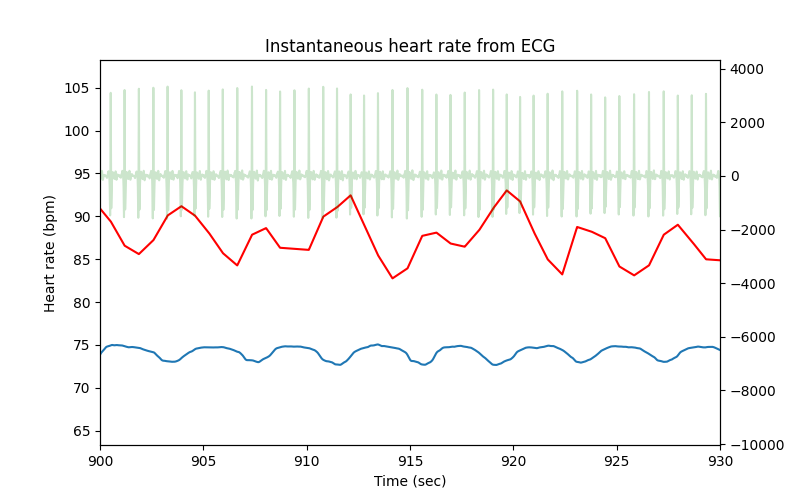

In [41]:


fig, ax = plt.subplots(figsize = (8,5))

ax.plot(rate_times, instantaneous_cardiac_rate, color = 'r')
ax.set_ylabel('Heart rate (bpm)')
ax.set_title('Instantaneous heart rate from ECG')

ax2 = ax.twinx()
ax2.plot(times, resp*4)
ax2.plot(times, ecg * 100,  alpha=0.2 , color = 'g')

ax.set_xlabel('Time (sec)')

ax.set_xlim(900, 930)
# ax.set_ylim(80, 90)

## Epoching & streching heart rate signal

In [52]:
points_per_cycle = 100
one_cycle = np.arange(points_per_cycle) / points_per_cycle

# two segments respiratory cycle strech
cycle_times = resp_cycles[['inspi_time', 'expi_time','next_inspi_time']].values
inspi_ratio = np.mean((cycle_times[:, 1] - cycle_times[:, 0]) / (cycle_times[:, 2] - cycle_times[:, 0]))
segment_ratios = [inspi_ratio]

cyclic_resp_2seg = physio.deform_traces_to_cycle_template(resp, times, cycle_times,
                                                points_per_cycle=points_per_cycle, segment_ratios=segment_ratios)

# two segments cyclic cardiac rate
cycle_times = resp_cycles[['inspi_time', 'expi_time','next_inspi_time']].values
inspi_ratio = np.mean((cycle_times[:, 1] - cycle_times[:, 0]) / (cycle_times[:, 2] - cycle_times[:, 0]))

segment_ratios = [inspi_ratio]

cyclic_cardiac_rate_2seg = physio.deform_traces_to_cycle_template(instantaneous_cardiac_rate, rate_times, cycle_times,
                                                points_per_cycle=points_per_cycle, segment_ratios=segment_ratios)

(0.0, 1.0)

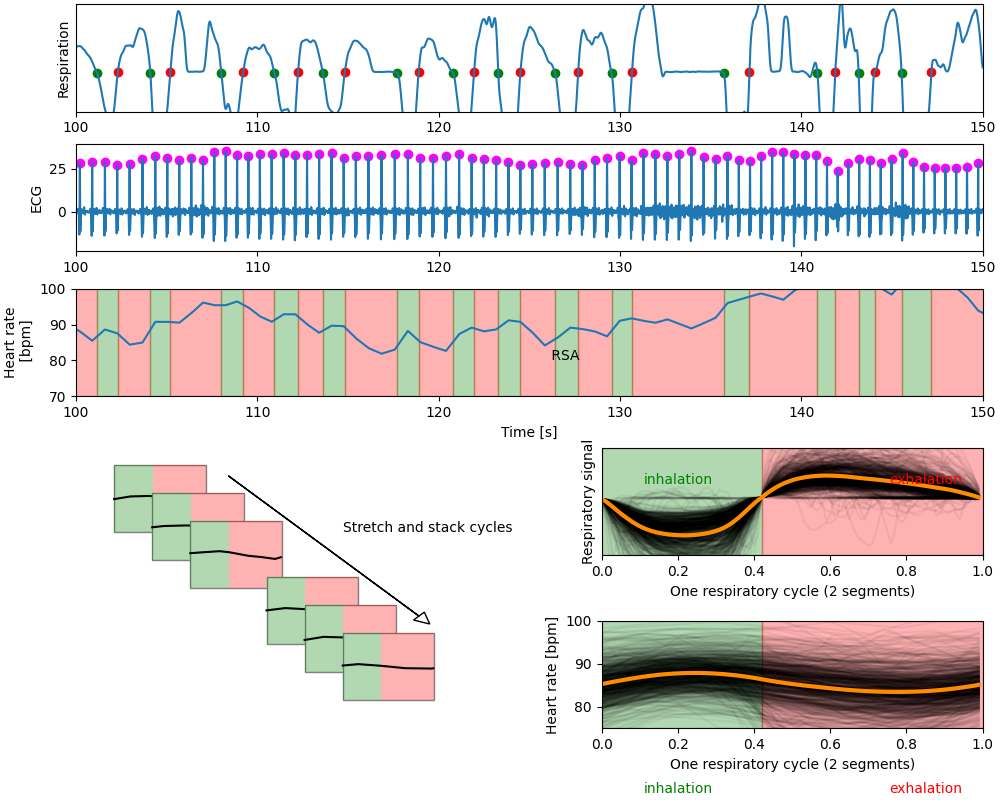

In [53]:
# Many ugly matplotlib code for a quite clear figure…

fig = plt.figure(layout="constrained", figsize=(10, 8))
gs = plt.GridSpec(nrows=5, ncols=4, figure=fig)

ax = ax_A = fig.add_subplot(gs[0, :])

ax.set_ylabel('Respiration')
ax.plot(times, resp)
inspi_index = resp_cycles['inspi_index'].values
expi_index = resp_cycles['expi_index'].values
ax.scatter(times[inspi_index], resp[inspi_index], marker='o', color='green')
ax.scatter(times[expi_index], resp[expi_index], marker='o', color='red')
ax.set_yticks([])
ax.set_ylim(-1750, -1450)

ax = ax_B = fig.add_subplot(gs[1, :],  sharex=ax)
ax.set_ylabel('ECG')

ax.plot(times, ecg)
ecg_peak_ind = ecg_peaks['peak_index'].values
ax.scatter(times[ecg_peak_ind], ecg[ecg_peak_ind], marker='o', color='magenta')

ax = ax_C = fig.add_subplot(gs[2, :], sharex=ax)
ax.set_ylabel('Heart rate\n [bpm]')
ax.plot(rate_times, instantaneous_cardiac_rate)
for c, cycle in resp_cycles.iterrows():
    ax.axvspan(cycle['inspi_time'], cycle['expi_time'], color='g', alpha=0.3)
    ax.axvspan(cycle['expi_time'], cycle['next_inspi_time'], color='r', alpha=0.3)
ax.set_ylim(70, 100)
ax.set_xlim(100, 150)
ax.annotate(text='', xy=(126,104), xytext=(126, 63), arrowprops=dict(arrowstyle='<->'))
ax.text(126, 80, ' RSA', ha='left')
ax.set_xlabel('Time [s]')


ax = ax_D = fig.add_subplot(gs[3:, :2])
for k in ('top', 'right', 'left', 'bottom'):
    ax.spines[k].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
w = 120.
rectangles = []
for i in range(7):
    if i in (3, ):
        continue
    z = (i + 1) * 10
    x = 100 + i * 50
    y = 400 - i * 50
    rect = plt.Rectangle((x, y), w, w, ec='gray', fc='w', zorder=z+1)
    ax.add_patch(rect)
    rect = plt.Rectangle((x, y), w*inspi_ratio, w, ec=None, fc='g', alpha=0.3, zorder=z+2)
    ax.add_patch(rect)
    rect = plt.Rectangle((x + w * inspi_ratio, y), w * (1 - inspi_ratio), w,  ec=None, fc='r', alpha=0.3, zorder=z+3)
    ax.add_patch(rect)
    cycle_phase = np.arange(points_per_cycle) / points_per_cycle
    cycle_value = cyclic_cardiac_rate_2seg[i, :]
    ax.plot(cycle_phase * w + x, cycle_value + y + w /2 - np.mean(cycle_value), color='black', zorder=z + 5)
ax.arrow(250, 500, 250, -250, head_width=20, head_length=20, fc='w', ec='k')
ax.text(400, 400, "Stretch and stack cycles")


ax.set_xlim(50, 550)
ax.set_ylim(50, 550)


ax = ax_E = fig.add_subplot(gs[3, 2:])
ax.plot(one_cycle, cyclic_resp_2seg.T, color='k', alpha=0.05)
ax.plot(one_cycle, np.mean(cyclic_resp_2seg, axis=0), color='darkorange', lw=3)
ax.axvspan(0, inspi_ratio, color='g', alpha=0.3)
ax.axvspan(inspi_ratio, 1, color='r', alpha=0.3)
ax.set_ylabel('Respiratory signal')
ax.text(0.2, -1600, 'inhalation', ha='center', color='g')
ax.text(0.85, -1600, 'exhalation', ha='center', color='r')
ax.set_xlabel('One respiratory cycle (2 segments)')
ax.set_xlim(0, 1)
ax.set_yticks([])
ax.set_ylim(-1800, -1500)


ax = ax_F = fig.add_subplot(gs[4, 2:])
ax.plot(one_cycle, cyclic_cardiac_rate_2seg.T, color='k', alpha=0.05)
ax.plot(one_cycle, np.mean(cyclic_cardiac_rate_2seg, axis=0), color='darkorange', lw=3)
ax.axvspan(0, inspi_ratio, color='g', alpha=0.3)
ax.axvspan(inspi_ratio, 1, color='r', alpha=0.3)
ax.set_ylim(75, 100)
ax.set_ylabel('Heart rate [bpm]')
ax.text(0.2, 60, 'inhalation', ha='center', color='g')
ax.text(0.85, 60, 'exhalation', ha='center', color='r')
ax.set_xlabel('One respiratory cycle (2 segments)')
ax.set_xlim(0, 1)




## RSA metrics

In [46]:
points_per_cycle = 50

rsa_cycles, cyclic_cardiac_rate = physio.compute_rsa(
    resp_cycles,
     ecg_peaks,
     srate=10.,
     two_segment=True,
     points_per_cycle=points_per_cycle,
)

rsa_cycles

,peak_index,trough_index,peak_time,trough_time,peak_value,trough_value,rising_amplitude,decay_amplitude,rising_duration,decay_duration,rising_slope,decay_slope
0,20,47,2.064,4.764,91.735537,83.434173,NaN,8.301364,NaN,2.7,NaN,3.074579
1,61,75,6.138,7.538,89.057695,86.114855,5.623522,2.942840,1.374,1.4,4.092811,2.102029
2,89,117,8.941,11.741,91.439804,77.639347,5.324948,13.800457,1.403,2.8,3.795402,4.928735
3,132,146,13.260,14.660,87.947620,82.100996,10.308273,5.846624,1.519,1.4,6.786223,4.176160
4,160,175,16.054,17.554,86.905449,79.062101,4.804453,7.843348,1.394,1.5,3.446523,5.228899
...,...,...,...,...,...,...,...,...,...,...,...,...
809,31661,31676,3166.188,3167.688,84.086133,79.240635,7.201606,4.845497,2.250,1.5,3.200714,3.230332
810,31691,31712,3169.136,3171.236,86.431773,80.583848,7.191138,5.847924,1.448,2.1,4.966255,2.784726
811,31727,31740,3172.700,3174.000,88.360901,86.341211,7.777053,2.019690,1.464,1.3,5.312195,1.553608
812,31754,31781,3175.443,3178.143,90.451139,88.110368,4.109928,2.340771,1.443,2.7,2.848183,0.866952


In [47]:
rsa_cycles.mean()

peak_index          14942.180590
trough_index        14960.775184
peak_time            1494.268274
trough_time          1496.127733
peak_value             88.503938
trough_value           83.020898
rising_amplitude        5.481469
decay_amplitude         5.483040
rising_duration         2.049055
decay_duration          1.859459
rising_slope            3.096551
decay_slope             2.991722
dtype: float64